# SHAP MNIST

This notebook shows how SHAP works using the MNIST dataset and a PyTorch model.

The code is based on the [SHAP MNIST example](https://shap.readthedocs.io/en/stable/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html). The notebook with the example code is available [on GitHub](https://github.com/slundberg/shap/blob/master/notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.ipynb).

## Neural network training

In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [2]:
batch_size = 128
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [3]:
num_epochs = 1 
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315850
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.934192
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.025891
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.958118
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.621707

Test set: Average loss: 0.0043, Accuracy: 8992/10000 (90%)



## SHAP feature attributions

Extract a batch of images and their labels from the test set.

In [4]:
batch = next(iter(test_loader))
images, target = batch

datad, targetd = images.to(device), target.to(device)

Get their predicted probabilities and predicted label (with argmax).

In [5]:
output = model(datad)
pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

"Select a set of background examples to take an expectation over" (from the [SHAP README](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models))

In [6]:
BACKGROUND_SIZE = 100
background = images[:BACKGROUND_SIZE]
e = shap.DeepExplainer(model, background)

What is left from the test batch will be used to show feature attribution.

In [7]:
test_images = images[BACKGROUND_SIZE:]

Show the SHAP feature atribution for each image. We could have passed the entire array of images to `image_plot`, but we would lose resolution with that (see the test code). Processing each image separately results in a larger graph, making the attributions easier to see.

Predicted 6
Actual 6
[7.3082801e-03 3.1878070e-03 2.3747377e-02 4.6645701e-03 1.9250942e-02
 3.6023546e-02 8.5809922e-01 4.1316028e-04 4.4212312e-02 3.0927679e-03]


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


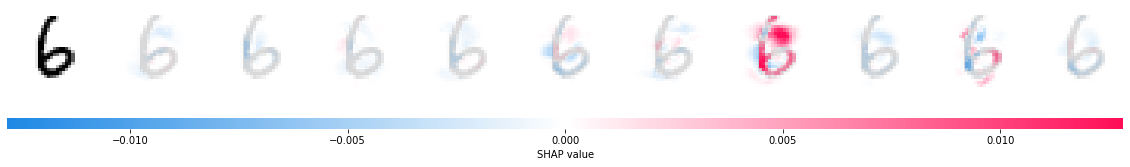

Predicted 3
Actual 3
[0.027787   0.11256289 0.25862998 0.41352823 0.00510556 0.06575907
 0.01350461 0.03132925 0.05437686 0.01741658]


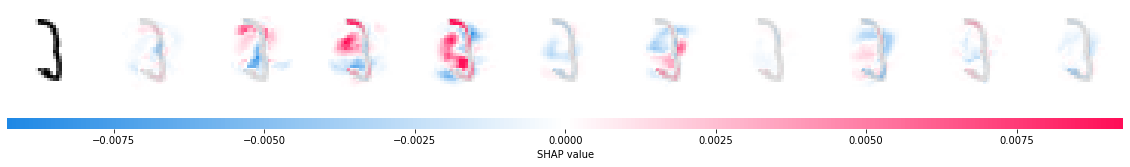

Predicted 3
Actual 3
[0.02443105 0.02854395 0.05290612 0.7134692  0.00211362 0.11601833
 0.00209783 0.00764293 0.0411627  0.01161418]


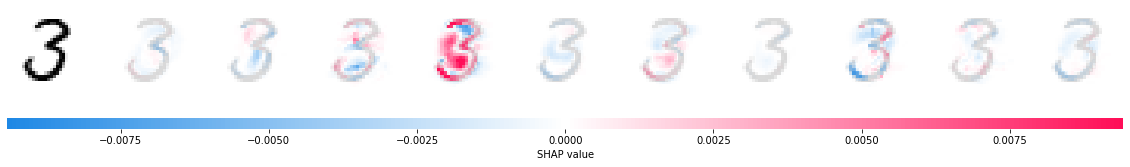

Predicted 7
Actual 7
[1.5413335e-04 2.4872148e-04 6.2694272e-04 6.2019201e-03 5.0879607e-04
 2.7692206e-03 2.5254699e-06 9.1911811e-01 2.8604406e-03 6.7509197e-02]


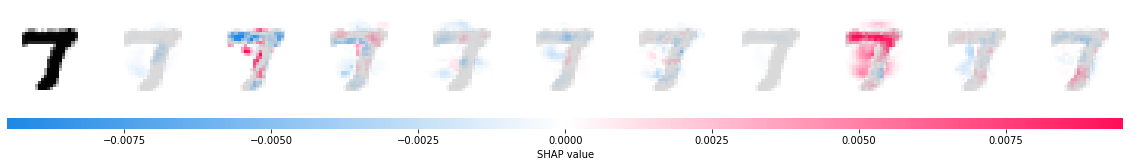

Predicted 5
Actual 5
[4.9995579e-02 5.8801810e-04 6.1163488e-03 9.4791695e-02 6.0965715e-04
 7.8149623e-01 4.2209929e-04 4.4391761e-03 5.6273747e-02 5.2674981e-03]


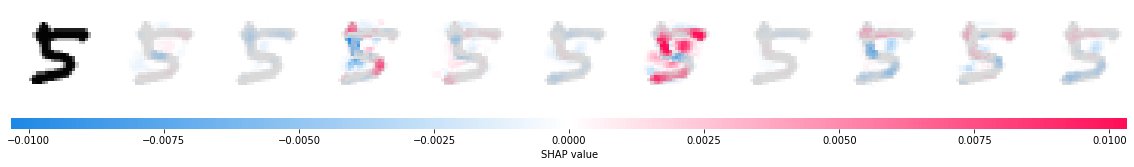

Predicted 4
Actual 6
[0.00082509 0.0016125  0.05441001 0.00067225 0.4970303  0.00273353
 0.41489303 0.00120764 0.01007774 0.01653785]


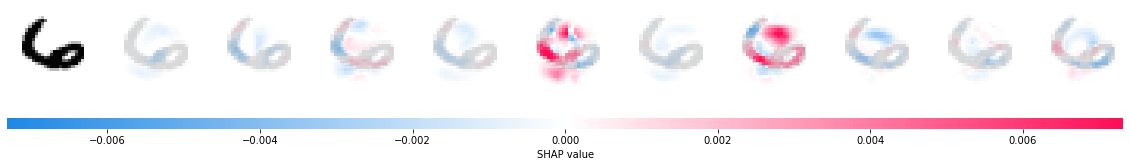

Predicted 5
Actual 5
[0.02350058 0.01934093 0.00457975 0.25145254 0.00199527 0.62602496
 0.004133   0.00711598 0.04369986 0.0181572 ]


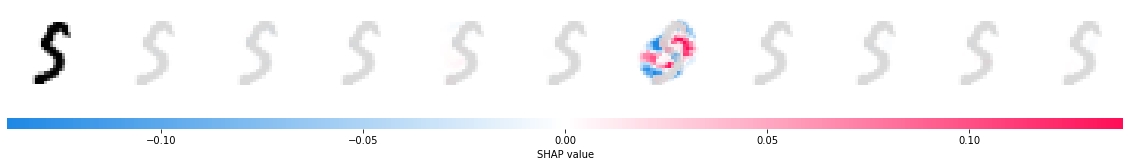

Predicted 9
Actual 9
[0.00526561 0.00420349 0.02277665 0.008802   0.2552523  0.01831022
 0.01659501 0.08681116 0.05905037 0.5229332 ]


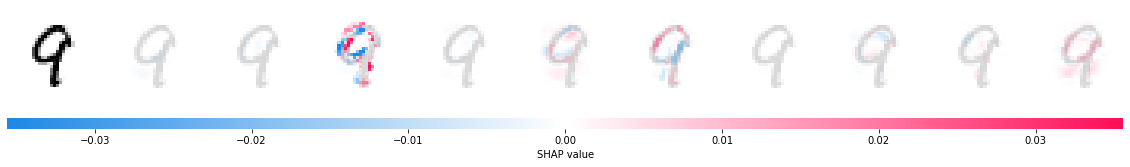

Predicted 8
Actual 8
[0.03246015 0.00892311 0.06250919 0.15249744 0.02321974 0.1777924
 0.0048937  0.08207596 0.38501748 0.0706108 ]


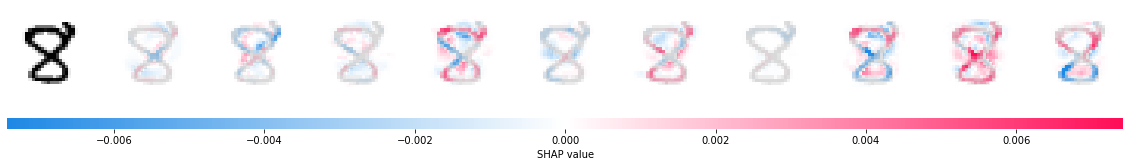

Predicted 3
Actual 3
[5.2614041e-02 5.6931349e-03 5.0869294e-02 5.8166611e-01 5.2207930e-04
 2.6634082e-01 1.7098831e-03 1.3615421e-03 3.4412690e-02 4.8104594e-03]


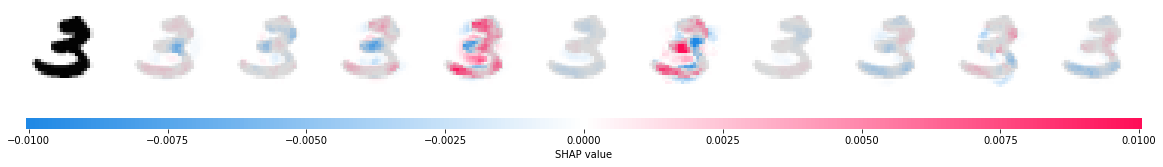

Predicted 0
Actual 0
[0.62410694 0.00161817 0.01637906 0.01444627 0.00241481 0.28936368
 0.02355474 0.00519285 0.0135369  0.0093866 ]


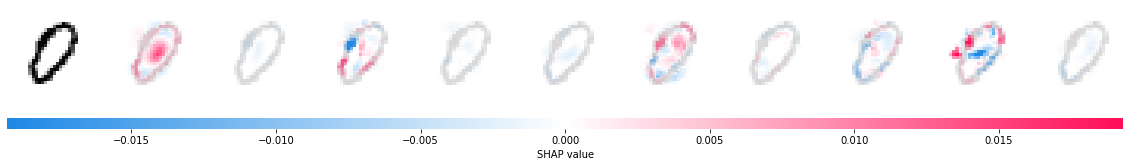

Predicted 3
Actual 3
[6.7194495e-03 9.6664578e-03 3.8833935e-02 7.1394432e-01 1.6727103e-03
 7.2200157e-02 3.9418740e-04 3.8166225e-02 9.1762044e-02 2.6640471e-02]


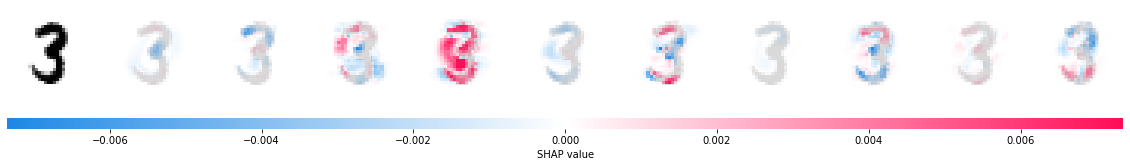

Predicted 5
Actual 8
[0.08654025 0.00316398 0.03127047 0.02078748 0.03180445 0.41502732
 0.02892839 0.01429636 0.3271724  0.04100895]


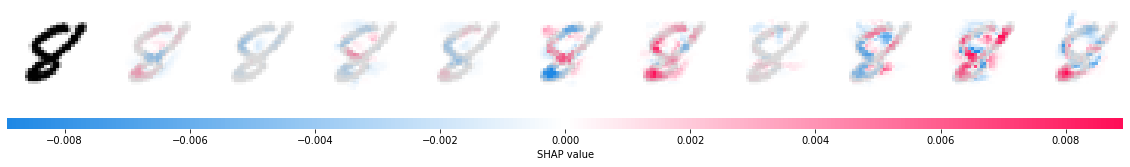

Predicted 5
Actual 5
[0.11698905 0.01256193 0.01353494 0.12898207 0.00525613 0.63471794
 0.01963118 0.00874558 0.03980692 0.01977433]


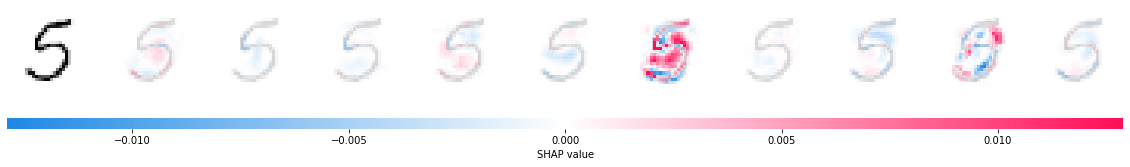

Predicted 0
Actual 0
[9.5437282e-01 2.3197450e-05 6.2388103e-03 1.1975055e-03 1.0365033e-04
 3.0466568e-02 5.4106913e-03 2.6249743e-04 1.2407557e-03 6.8339350e-04]


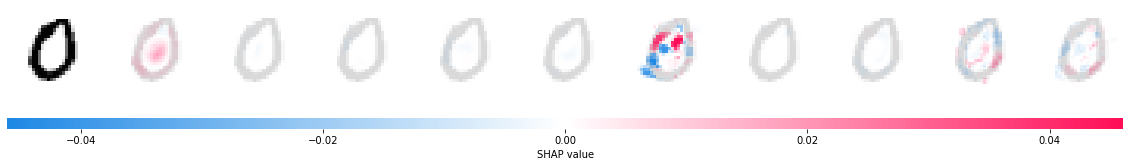

Predicted 8
Actual 8
[0.03336492 0.00917163 0.21337058 0.11047471 0.01880486 0.10029512
 0.03663    0.02548531 0.42874607 0.02365679]


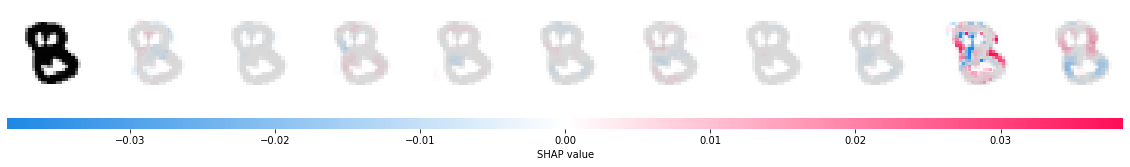

Predicted 8
Actual 8
[0.01646045 0.03193608 0.03735569 0.07985425 0.02175766 0.14429823
 0.01975696 0.02484789 0.59398466 0.02974812]


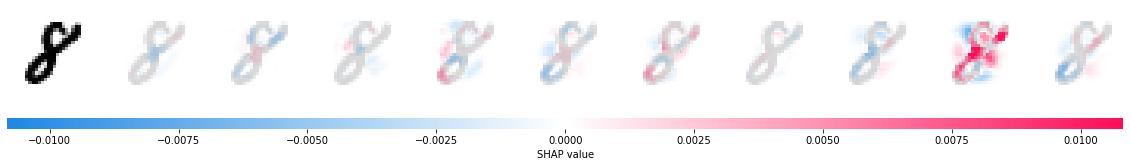

Predicted 2
Actual 2
[0.03138249 0.00943832 0.5924213  0.10955299 0.00723008 0.02416936
 0.01437192 0.08807623 0.09884267 0.02451464]


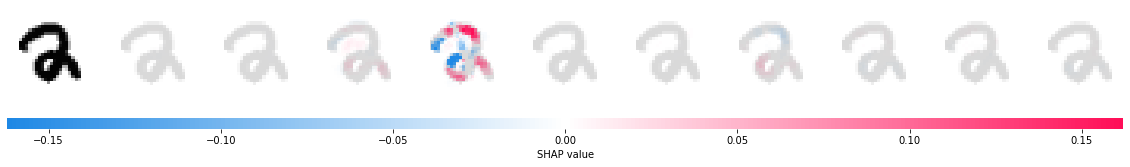

Predicted 6
Actual 0
[0.24585113 0.00422448 0.09120737 0.02294364 0.03586692 0.11400442
 0.38252905 0.00706748 0.05543447 0.04087099]


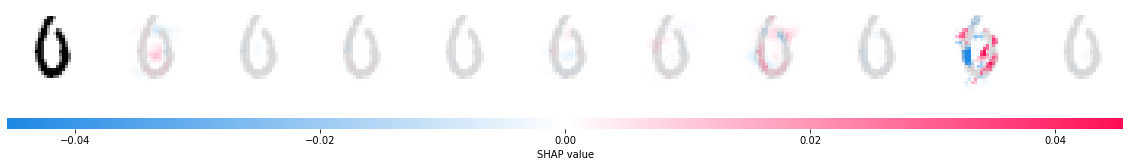

Predicted 2
Actual 2
[8.3542510e-04 2.8404235e-03 9.4961435e-01 2.8198354e-02 3.5969191e-05
 1.2233950e-03 2.3546612e-03 1.5990752e-04 1.4698421e-02 3.9048056e-05]


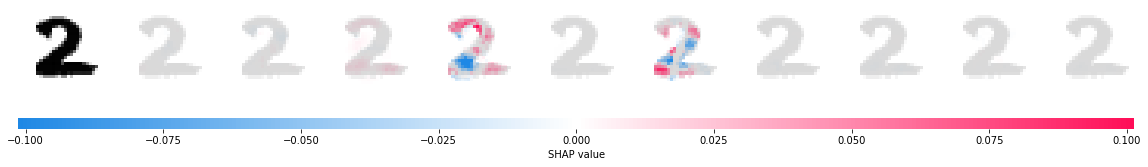

Predicted 6
Actual 6
[0.04529383 0.01477158 0.01455222 0.02673283 0.01400441 0.28139895
 0.54784644 0.00081292 0.04761505 0.00697183]


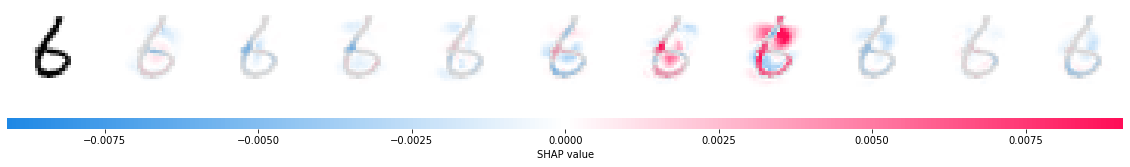

Predicted 8
Actual 8
[0.01182387 0.11361518 0.04760058 0.23955733 0.03568891 0.16038954
 0.01994015 0.05099346 0.25625503 0.06413607]


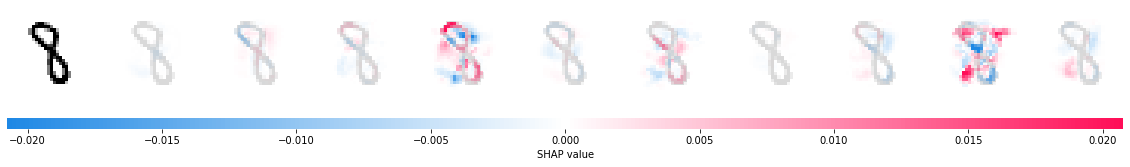

Predicted 2
Actual 2
[0.00384366 0.02132473 0.90504384 0.01935365 0.00179319 0.00408205
 0.02433338 0.00288872 0.0157973  0.00153937]


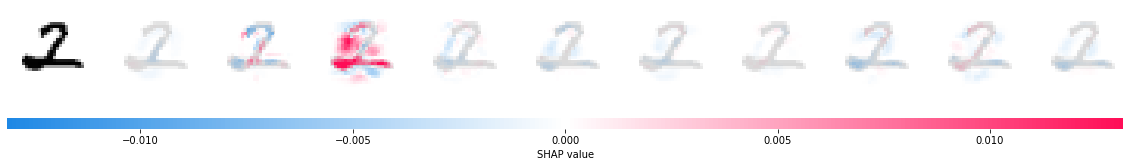

Predicted 2
Actual 2
[3.9970214e-03 3.4537091e-04 9.7881377e-01 1.0894295e-02 7.3937736e-05
 7.5011002e-04 1.9310497e-03 2.1027296e-04 2.7100823e-03 2.7414254e-04]


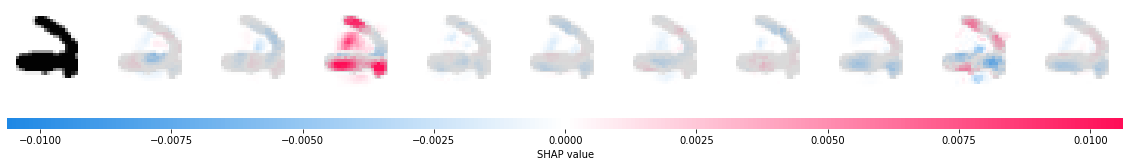

Predicted 1
Actual 1
[0.00796161 0.330844   0.09115089 0.24965493 0.01850877 0.0884331
 0.02998595 0.03334427 0.11648391 0.03363253]


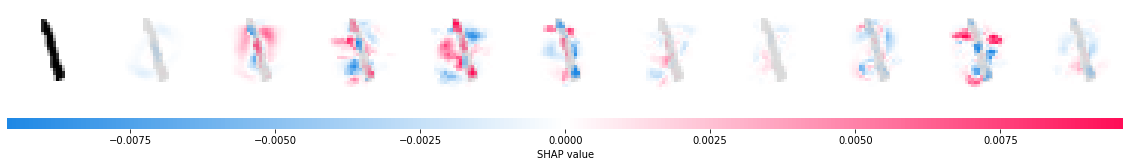

Predicted 4
Actual 4
[0.00206734 0.01673636 0.0309323  0.00932177 0.595945   0.01242261
 0.05159961 0.02431505 0.03714506 0.21951495]


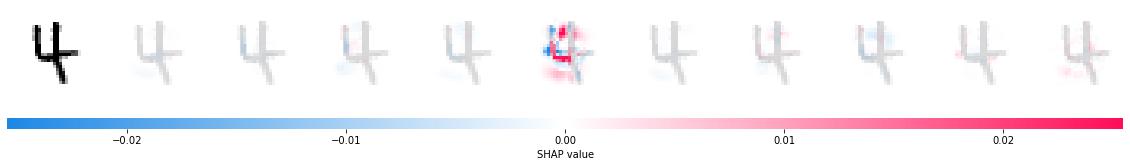

Predicted 0
Actual 0
[8.3212548e-01 6.5425457e-04 3.8459372e-02 1.8019792e-02 1.3280623e-03
 5.4959513e-02 3.8303549e-03 2.5480539e-02 9.5271226e-03 1.5615466e-02]


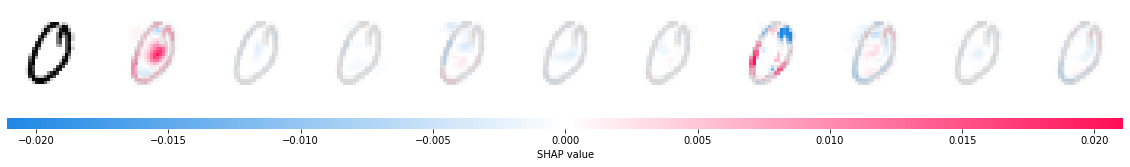

Predicted 7
Actual 7
[0.0075867  0.01705726 0.21264447 0.10248135 0.01685297 0.02014599
 0.00628791 0.432495   0.07783834 0.10661002]


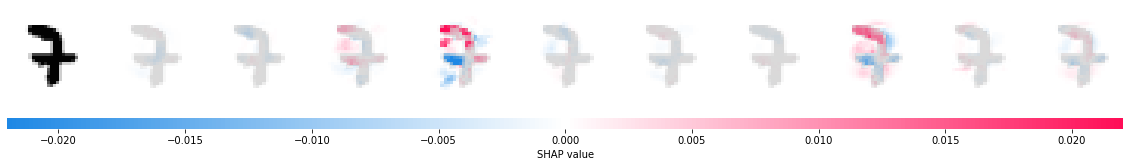

In [11]:
for i in range(0,len(test_images)):
    test_index = BACKGROUND_SIZE + i
    print('Predicted', pred.numpy()[test_index][0])
    print('Actual', target.numpy()[test_index])
    print(output[test_index].detach().numpy())

    ti = test_images[[i]]
    sv = e.shap_values(ti)
    sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
    tn = np.swapaxes(np.swapaxes(ti.numpy(), 1, -1), 1, 2)
    shap.image_plot(sn, -tn)


# Test code

This section has the original code from the notebook. Use this section to check that the code in the previous section is showing the correct SHAP images.

To make the code comparable, we reuse the same images loaded in the previous section, but we redo all calculations following the sample code, to ensure that we didn't introduce a bug in the previous section.

The sequence of digits in this section and their feature attributions must match the ones in the previous sections.

In [12]:
# Turn the test code on when needed to not pollute the noebook
TEST_CODE = True

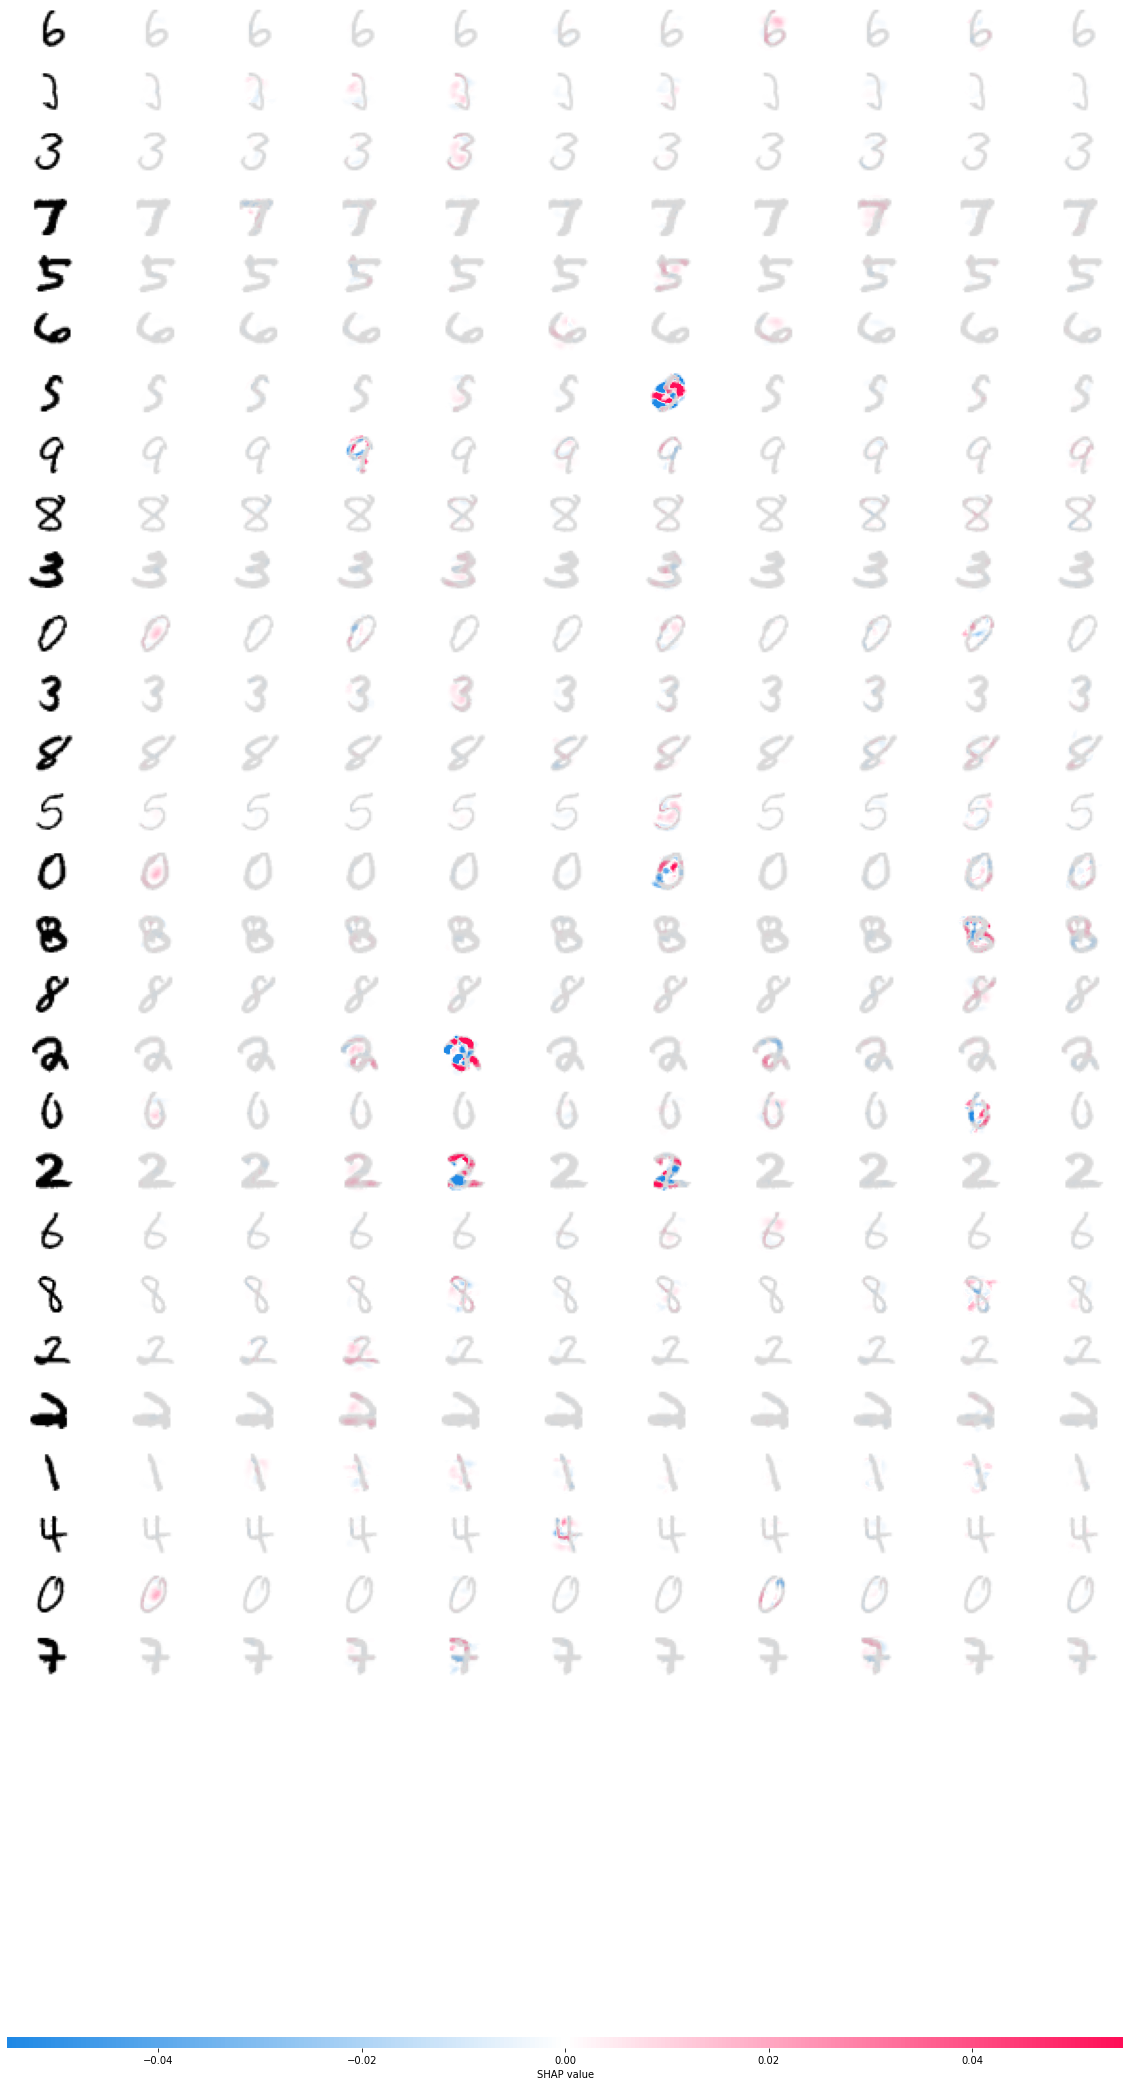

In [13]:
if TEST_CODE:
    e = shap.DeepExplainer(model, background)
    shap_values = e.shap_values(test_images)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
    
    shap.image_plot(shap_numpy, -test_numpy)